In [1]:
%matplotlib inline

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
def load_dataset(path, picsize):        
    classes = os.listdir(path)    
    
    images = []
    labels = []
    
    for cls in classes:
        cls_dir = os.path.join(path, cls)
        
        for filename in os.listdir(cls_dir):
            image_path = os.path.join(path, cls, filename)
                    
            image = Image.open(image_path)        
            image = image.convert("L")                    

            image = image.resize(picsize)
                        
            images.append(np.array(image, dtype=np.uint8).flatten())
            labels.append(cls)                    
    
    return np.array(images), np.array(labels)

In [3]:
def draw(vec, imsize=(168, 168)):
    plt.imshow(vec.reshape(imsize), cmap='gray')

In [4]:
def calculate_pca(X, num_components):
    n, d = X.shape
    
    num_components = min(num_components, n)
    
    mean = np.mean(X, axis=0)
    
    centered_data = (X - mean)    
        
    L = np.dot(centered_data, centered_data.T)
    
    eigenvalues, eigenvectors = np.linalg.eig(L)
    
    eigenvectors = np.dot(centered_data.T , eigenvectors)

    for i in range(n):
        eigenvectors [: , i] = eigenvectors [: , i] / np.linalg.norm(eigenvectors [: , i])        
    
    idx = np.argsort(-eigenvalues)    
    eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:, idx]
    
    return eigenvalues[:num_components], eigenvectors[:, :num_components], mean

In [5]:
def project(W, X, mean):
    return np.dot(X - mean, W)

In [6]:
def reconstruct(W, Y):
    return np.dot(Y, W.T)

In [7]:
def normalize(X, low=0, high=255):    
    min_x, max_x = np.min(X), np.max(X)
    
    X = X - float(min_x)
    X = X / float(max_x - min_x)
    
    X = X * (high - low)
    X = X + low
    
    return X

In [8]:
def compute_threshold(projections):
    n = len(projections)
    
    max_dist = float('-inf')
    
    for i in range(n):        
        for j in range(i+1, n):            
            dist = np.linalg.norm(projections[i] - projections[j])
            max_dist = max(max_dist, dist)
    
    return max_dist / 4

In [9]:
def closest_face(projections, labels, p):          
    distances = [np.linalg.norm(p - pi) for pi in projections]    
    
    sorted_distances_idx = np.argsort(distances)
    
    return labels[sorted_distances_idx[0]], distances[sorted_distances_idx[0]]

In [10]:
def predict(X, eigenvectors, projections, labels, meanface, threshold):
    y_pred = []
    
    for image in X:
        image = image.reshape(1, -1)
        
        p = project(eigenvectors, image, meanface)
        
        prediction, dist = closest_face(projections, labels, p)
        
        reconstructed = reconstruct(eigenvectors, p)
        
        rec_dist = np.linalg.norm((image - meanface) - reconstructed)
        
        if rec_dist >= threshold:
            y_pred.append('NotFace')
        
        elif dist >= threshold:            
            y_pred.append('NewFace')
        
        else:
            y_pred.append(prediction)
    
    return np.array(y_pred)

In [11]:
def calculate_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    accuracy = correct / total
    return accuracy

In [12]:
imsize = (168, 168)

x_train, y_train = load_dataset('yale_dataset/train', imsize)

In [13]:
num_components = 100

eigenvalues, eigenvectors, mean_face = calculate_pca(x_train, num_components)

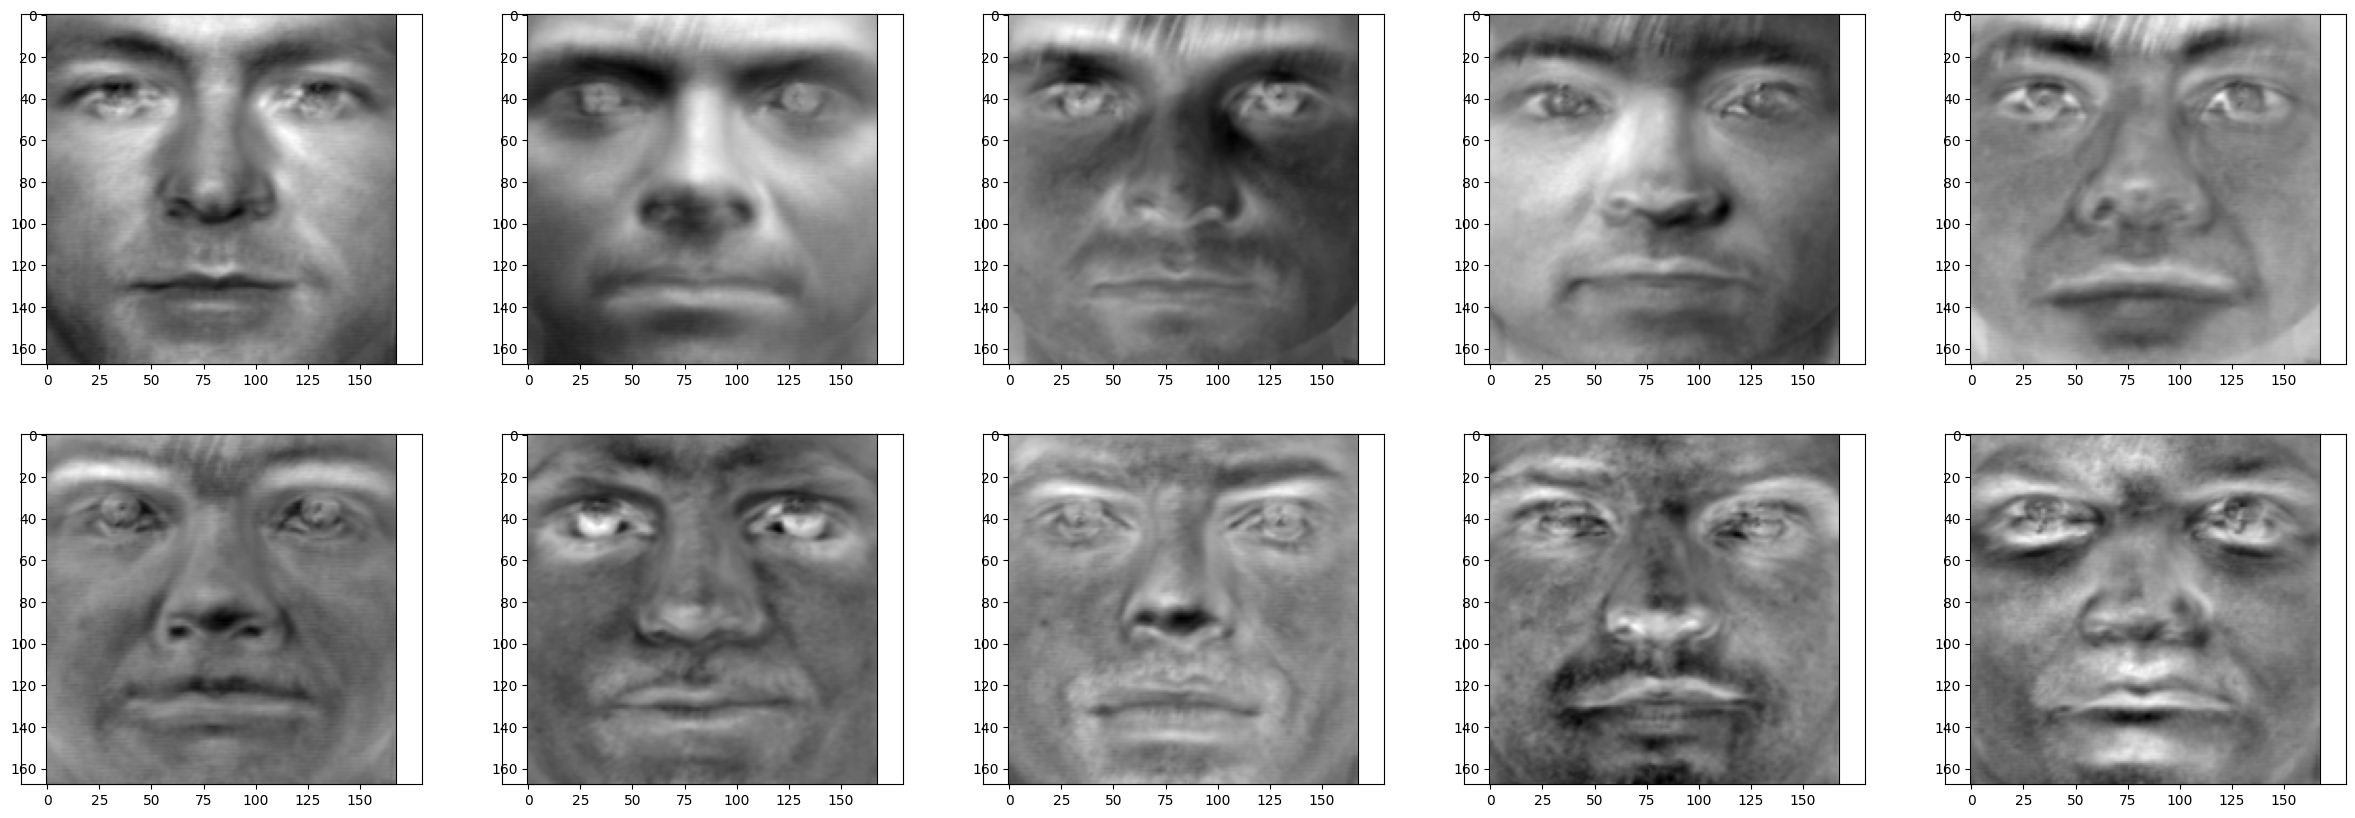

In [14]:
# first 10 eigenfaces

fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for i, face in enumerate(eigenvectors.T[:10]):    
    fig.add_subplot(2, 5, i + 1)
    draw(normalize(face))

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
projections = []

for image in x_train:
    projections.append(project(eigenvectors, image.reshape(1, -1), mean_face))

projections = np.array(projections)

In [16]:
threshold = compute_threshold(projections)

### Testing

In [17]:
def confusion_matrix(expected, predicted, classes):        
    c_idx = {cls: idx for idx, cls in enumerate(classes)}
        
    n = len(classes)
    
    cm = np.zeros((n, n))
    
    for y, y_pred in zip(expected, predicted):
        if y in c_idx and y_pred in c_idx:
            idx_y = c_idx[y]
            idx_pred = c_idx[y_pred]

            cm[idx_y][idx_pred] += 1
    
    return cm

In [18]:
def calc_accuracy(expected, predicted):
    return np.sum(expected.flatten() == predicted.flatten()) / len(expected)

In [19]:
x_test, y_test = load_dataset('yale_dataset/test', imsize)

In [20]:
y_pred = predict(x_test,
                 eigenvectors,
                 projections,
                 labels = y_train,
                 meanface = mean_face,
                 threshold = threshold)

In [21]:
classes  = np.unique(np.concatenate((y_train, ['NotFace', 'NewFace'])))

cm = confusion_matrix(y_test, y_pred, classes)

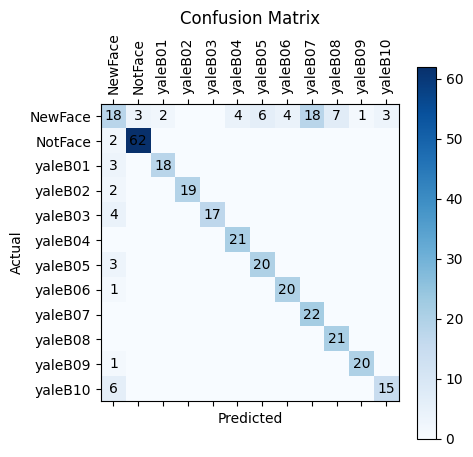

In [22]:
plt.matshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(range(len(classes)), classes, rotation=90)
plt.yticks(range(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        if cm[i, j] > 0:
            plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [23]:
accuracy = calc_accuracy(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.59%


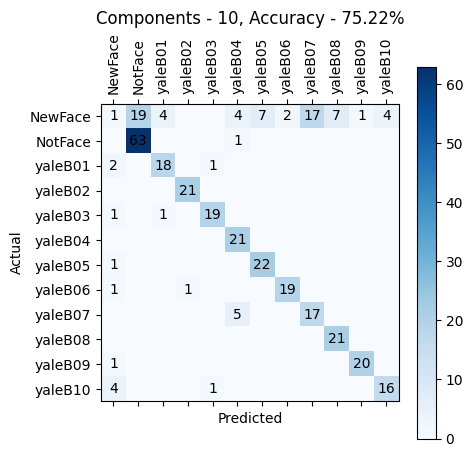

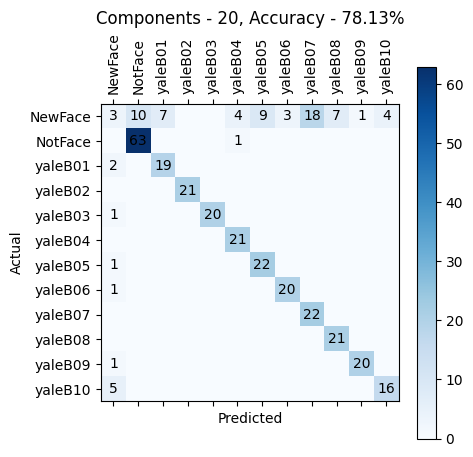

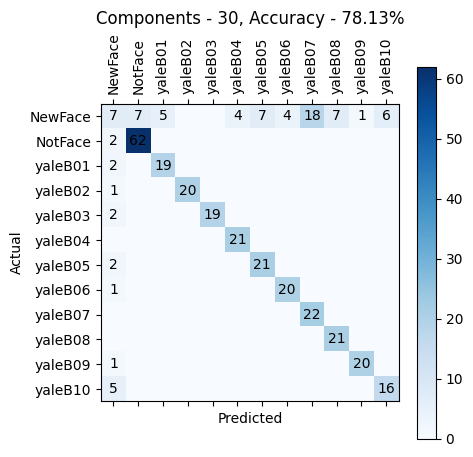

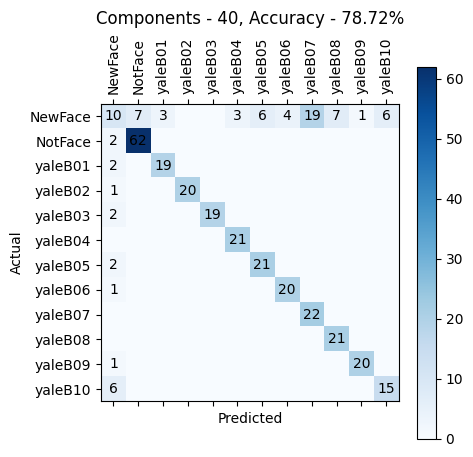

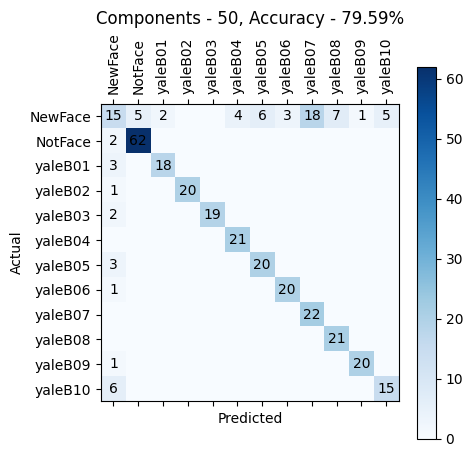

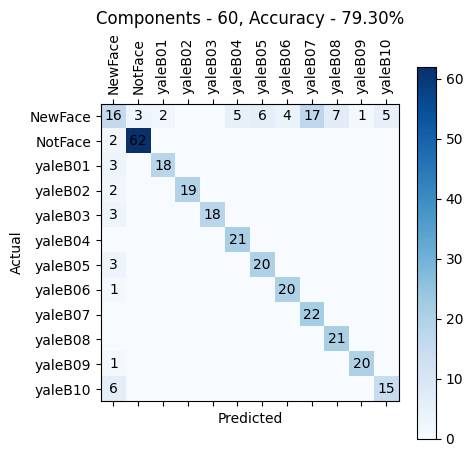

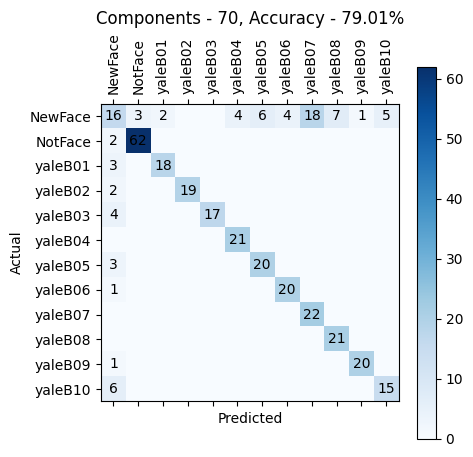

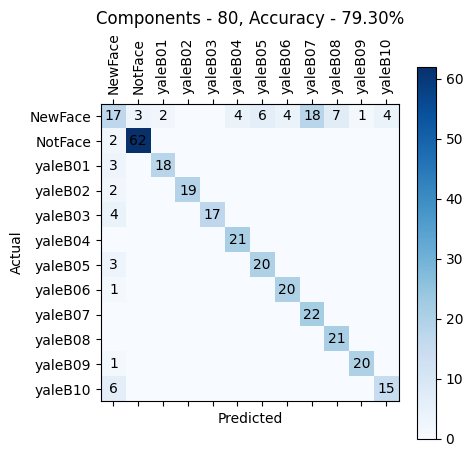

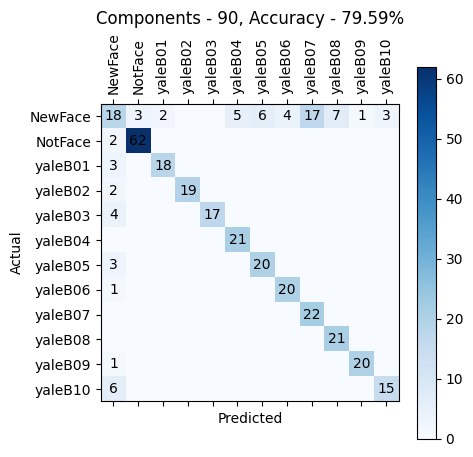

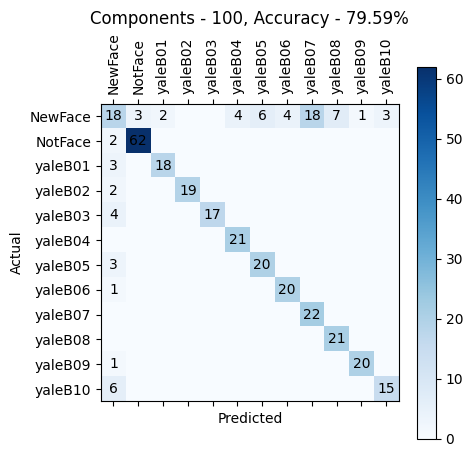

In [24]:
acc = []

n_components = [n for n in range(10, 101)]

for n in n_components:
    eigenvalues, eigenvectors, mean_face = calculate_pca(x_train, n)
    
    projections = []

    for image in x_train:
        projections.append(project(eigenvectors, image.reshape(1, -1), mean_face))

    projections = np.array(projections)
    
    threshold = compute_threshold(projections)
    
    y_pred = predict(x_test,
                 eigenvectors,
                 projections,
                 labels = y_train,
                 meanface = mean_face,
                 threshold = threshold)
    
    
    accuracy = calc_accuracy(y_test, y_pred)

    acc.append(accuracy * 100)
    
    if n % 10 == 0:    
        classes  = np.unique(np.concatenate((y_train, ['NotFace', 'NewFace'])))

        cm = confusion_matrix(y_test, y_pred, classes)

        plt.matshow(cm, cmap="Blues")
        plt.colorbar()

        plt.xticks(range(len(classes)), classes, rotation=90)
        plt.yticks(range(len(classes)), classes)

        for i in range(len(classes)):
            for j in range(len(classes)):
                if cm[i, j] > 0:
                    plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")

        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Components - {n}, Accuracy - {accuracy * 100:.2f}%")

        plt.show()
    

Text(0.5, 1.0, 'Accuracy vs Principal components')

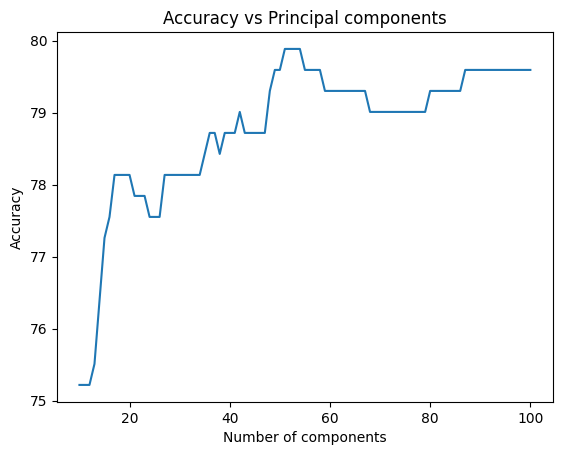

In [25]:
plt.plot(n_components, acc)
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Principal components")